# Sampling

In [2]:
using AutomotiveDrivingModels
using Distributions
using AutoScenes
using AutoViz
using NGSIM

In [3]:
trajdata = load_trajdata(1);

Interact.Options{:ToggleButtons,AutomotiveDrivingModels.AutoCore.LaneTag}(Signal{AutomotiveDrivingModels.AutoCore.LaneTag}(LaneTag(3, 1), nactions=0),"lanetag",LaneTag(3, 1),"LaneTag(3, 1)",Interact.OptionDict(Any["LaneTag(3, 1)","LaneTag(3, 2)","LaneTag(3, 3)","LaneTag(3, 4)","LaneTag(3, 5)","LaneTag(3, 6)","LaneTag(1, 1)","LaneTag(1, 2)","LaneTag(1, 3)","LaneTag(1, 4)","LaneTag(1, 5)","LaneTag(2, 1)","LaneTag(4, 1)","LaneTag(4, 2)","LaneTag(4, 3)","LaneTag(4, 4)","LaneTag(4, 5)","LaneTag(5, 1)"],Dict{Any,Any}("LaneTag(1, 3)"=>LaneTag(1, 3),"LaneTag(4, 4)"=>LaneTag(4, 4),"LaneTag(2, 1)"=>LaneTag(2, 1),"LaneTag(3, 1)"=>LaneTag(3, 1),"LaneTag(4, 5)"=>LaneTag(4, 5),"LaneTag(3, 2)"=>LaneTag(3, 2),"LaneTag(5, 1)"=>LaneTag(5, 1),"LaneTag(4, 1)"=>LaneTag(4, 1),"LaneTag(4, 3)"=>LaneTag(4, 3),"LaneTag(1, 4)"=>LaneTag(1, 4),"LaneTag(3, 4)"=>LaneTag(3, 4),"LaneTag(1, 2)"=>LaneTag(1, 2),"LaneTag(3, 6)"=>LaneTag(3, 6),"LaneTag(1, 5)"=>LaneTag(1, 5),"LaneTag(1, 1)"=>LaneTag(1, 1),"LaneTag(3, 5)"=>LaneTag(3, 5),"LaneTag(3, 3)"=>LaneTag(3, 3),"LaneTag(4, 2)"=>LaneTag(4, 2))),Any[],Any[])

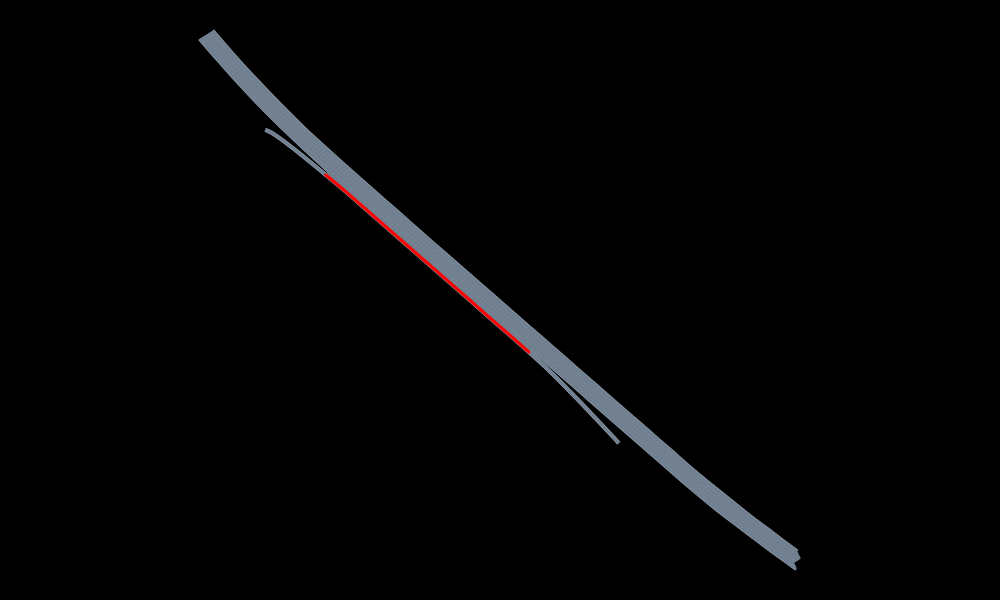

In [7]:
using Interact
using Cairo

roadway = trajdata.roadway

lanetags = LaneTag[]
for seg in roadway.segments
    for lane in seg.lanes
        push!(lanetags, lane.tag)
    end
end

canvas_width = AutoViz.DEFAULT_CANVAS_WIDTH
canvas_height = AutoViz.DEFAULT_CANVAS_HEIGHT
rendermodel = RenderModel()
cam = FitToContentCamera()

@manipulate for lanetag in lanetags
    
    s = CairoRGBSurface(canvas_width, canvas_height)
    ctx = creategc(s)
    clear_setup!(rendermodel)

    render!(rendermodel, roadway)
    render!(rendermodel, roadway[lanetag], roadway, color_asphalt=colorant"red")
    
    camera_set!(rendermodel, cam, canvas_width, canvas_height)
    render(rendermodel, ctx, canvas_width, canvas_height)
    s
end

In [3]:
const REGIONS = Dict{ASCIIString, SubSceneExtractParams}(
  "101A" => SubSceneExtractParams(VecSE2(1966406.608, 570903.793, 2.382), 100.0, 27.0),  
  "101B" => SubSceneExtractParams(VecSE2(1966501.608, 570804.793, 2.425), 100.0, 25.0),
  "101C" => SubSceneExtractParams(VecSE2(1966406.608, 570903.793, 2.382), 100.0, 25.0),
  "80A"  => SubSceneExtractParams(VecSE2(6042777.824, 2133302.509, 1.684)),
  "80B"  => SubSceneExtractParams(VecSE2(6042697.824, 2134372.509, 1.745)),
  )

Dict{ASCIIString,AutoScenes.SubSceneExtractParams} with 5 entries:
  "80A"  => AutoScenes.SubSceneExtractParams(VecSE2({6042777.824, 2133302.509},…
  "101B" => AutoScenes.SubSceneExtractParams(VecSE2({1966501.608, 570804.793}, …
  "101A" => AutoScenes.SubSceneExtractParams(VecSE2({1966406.608, 570903.793}, …
  "80B"  => AutoScenes.SubSceneExtractParams(VecSE2({6042697.824, 2134372.509},…
  "101C" => AutoScenes.SubSceneExtractParams(VecSE2({1966406.608, 570903.793}, …

In [4]:
dset = pull_scene_dataset(trajdata, REGIONS["101B"])
length(dset)

736

In [5]:
sg = SceneGenerator(dset.factors, MvNormal([1.0,0.5,0.5,0.1]), 2)

SceneGenerator(burnin=2)

VecE2(1966503.419, 570807.108)


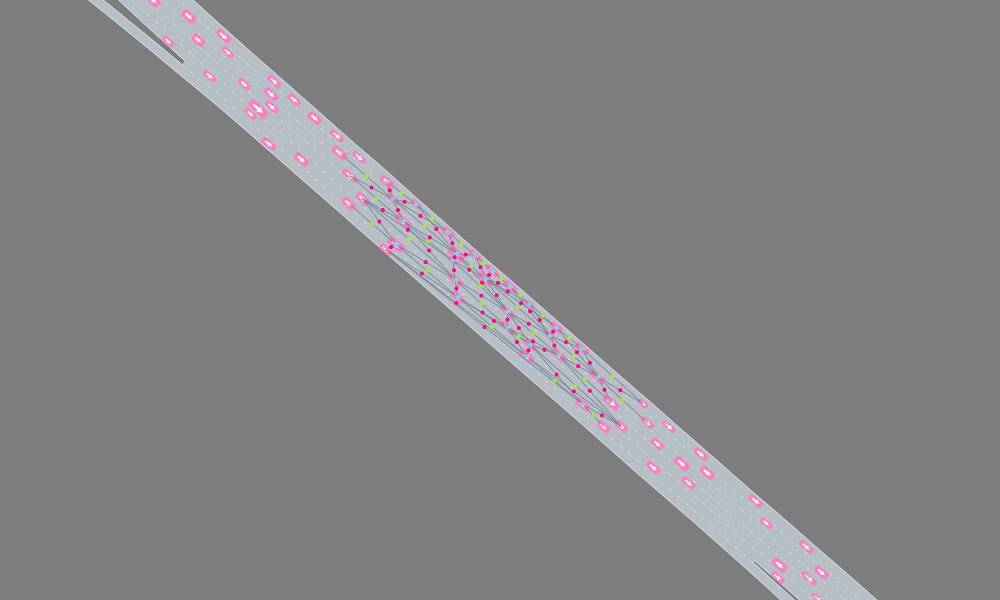

In [6]:
scene, source, structure, roadway = sample(sg, dset)

overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
render(scene, roadway, overlays, cam=SceneFollowCamera(3.0))

Interact.Slider{Int64}(Signal{Int64}(500, nactions=0),"i",500,1:1000,"d",true)

VecE2(1966497.176, 570813.407)
VecE2(1966497.176, 570813.407)


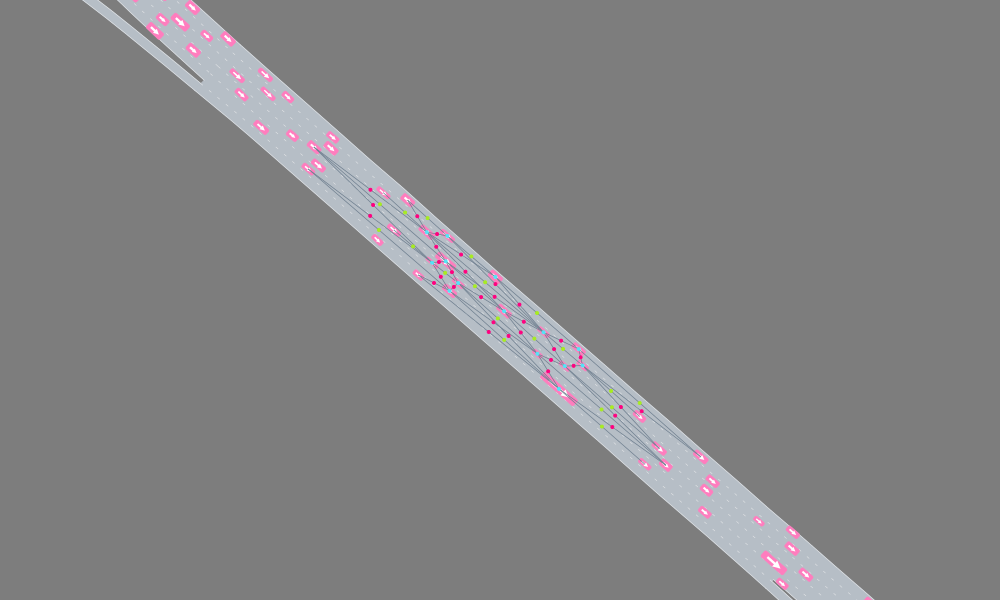

In [7]:
using Interact

starting_scene_index = rand(1:length(dset))
source = dset.sources[starting_scene_index]
scene, structure, roadway = get_scene_structure_and_roadway!(Scene(), dset, starting_scene_index)
overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]

@manipulate for i in 1 : 1000

    overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
    render(scene, roadway, overlays, cam=SceneFollowCamera(3.0))
    
    metropolis_hastings_step!(scene, structure, roadway, sg.factors,
                         sg.propsal_distribution, sg.Δ_propose, sg.mem, sg.rec)
    
    render(scene, roadway, overlays, cam=SceneFollowCamera(3.0))
end

In [8]:
sdset = sample(5, sg, dset)
length(sdset)

5

VecE2(1966513.695, 570798.113)


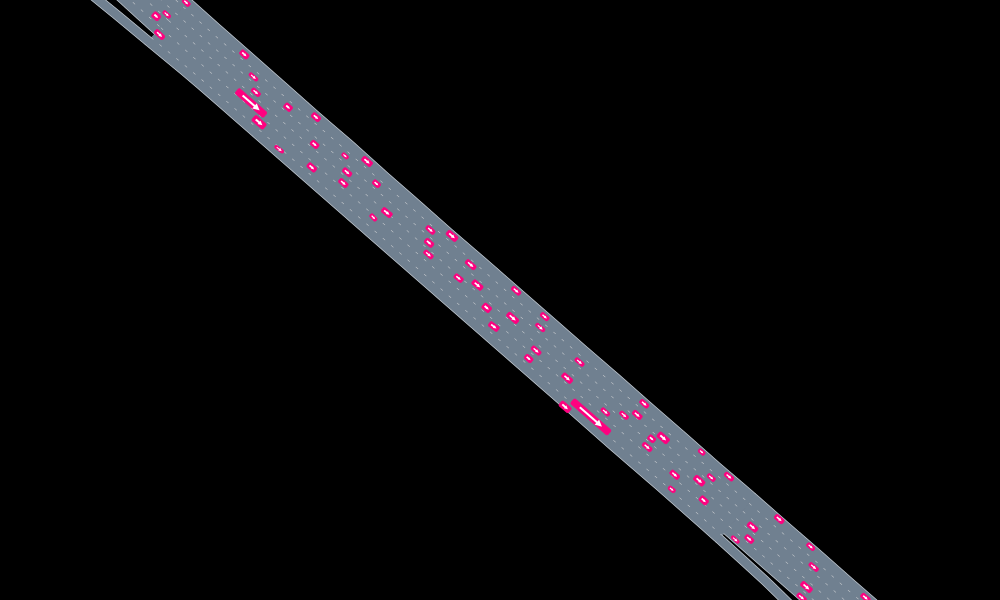

In [9]:
scene, roadway = get_scene_and_roadway!(Scene(), sdset, dset.trajdatas, 1)

render(scene, roadway, cam=SceneFollowCamera(3.0))

In [10]:
outpath = "scenedataset_test.dat"
open(io->write(io, sdset), outpath, "w")

VecE2(1966500.630, 570809.025)


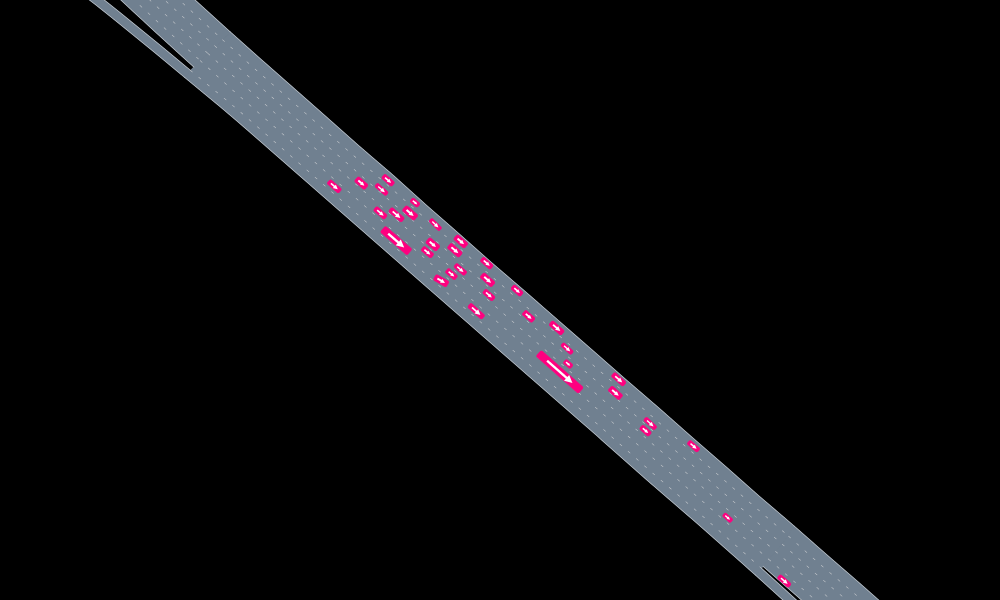

In [11]:
sdset2 = open(io->read(io, SceneDataset), outpath, "r")

scene, roadway = get_scene_and_roadway!(Scene(), sdset2, dset.trajdatas, 2, all_vehicles=false)

render(scene, roadway, cam=SceneFollowCamera(3.0))